# PW1 - Handwritten character recognition


In [1]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Ismael DEMBELE"    
assert your_name

In [1]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [4]:
NUM_EPOCH = 5
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [5]:
root_dir = './data/MNIST/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # μ, σ standard pour MNIST
])

train_data = datasets.MNIST(root=root_dir, train=True, download=True, transform=transform)
test_data   = datasets.MNIST(root=root_dir, train=False, download=True, transform=transform)

BATCH_SIZE=64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE)

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

In [6]:
print(f"Nombre d'exemples dans le train : {len(train_data)}")
print(f"Nombre d'exemples dans le test  : {len(test_data)}")

Nombre d'exemples dans le train : 60000
Nombre d'exemples dans le test  : 10000


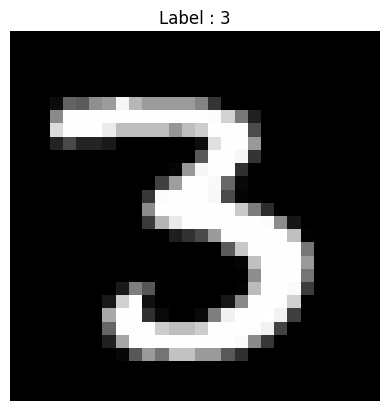

In [7]:
image, label = train_data[12]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label : {label}")
plt.axis('off')
plt.show()

In [8]:
print(f"Shape du tenseur image : {image.shape}")

Shape du tenseur image : torch.Size([1, 28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

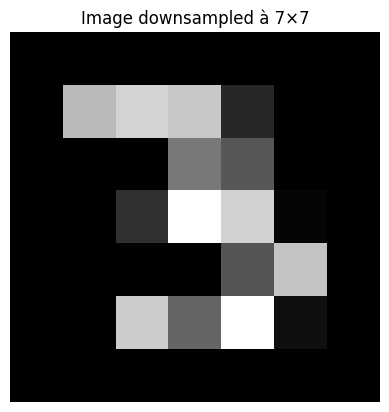

In [9]:
# Récupère une image
image, label = train_data[12]  # image: [1, 28, 28]

# Downsampling à 7x7
downsampled = F.interpolate(image.unsqueeze(0), size=(7, 7), mode='bilinear', align_corners=False)

# Affichage
plt.imshow(downsampled.squeeze(), cmap='gray')
plt.title("Image downsampled à 7×7")
plt.axis('off')
plt.show()

In [10]:
# 📊 Visualisation : désnormalisation pour affichage
def show_img(x):
    """Affiche une image MNIST normalisée"""
    x = x * 0.3081 + 0.1307  # Inverse Normalize
    plt.imshow(x.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

# 🧹 Prétraitement : pooling + flatten
def preprocess(x):
    x = F.avg_pool2d(x, kernel_size=4)  # [B, 1, 28, 28] → [B, 1, 7, 7]
    return x.view(x.size(0), -1)        # [B, 1, 7, 7] → [B, 49]

In [11]:
# Modèle linéaire : 49 entrées (7x7) → 10 classes
model = nn.Linear(49, 10)

# Fonction de coût et optimiseur
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Boucle d'entraînement
train_acc_list, test_acc_list, loss_list = [], [], []

for epoch in range(NUM_EPOCH):
    model.train()
    correct = total = 0
    total_loss = 0

    for x, y in train_loader:
        x = preprocess(x)
        preds = model(x)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_acc_list.append(acc)
    loss_list.append(total_loss / total)
    print(f"[Epoch {epoch+1}] Train acc: {acc*100:.2f}%, Loss: {total_loss/total:.4f}")

# 🧪 Évaluation finale
model.eval()
correct = total = 0

with torch.no_grad():
    for x, y in test_loader:
        x = preprocess(x)
        preds = model(x)
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")

[Epoch 1] Train acc: 82.25%, Loss: 0.6800
[Epoch 2] Train acc: 86.30%, Loss: 0.4778
[Epoch 3] Train acc: 86.87%, Loss: 0.4484
[Epoch 4] Train acc: 87.20%, Loss: 0.4337
[Epoch 5] Train acc: 87.38%, Loss: 0.4243

✅ Final Test Accuracy: 88.46%


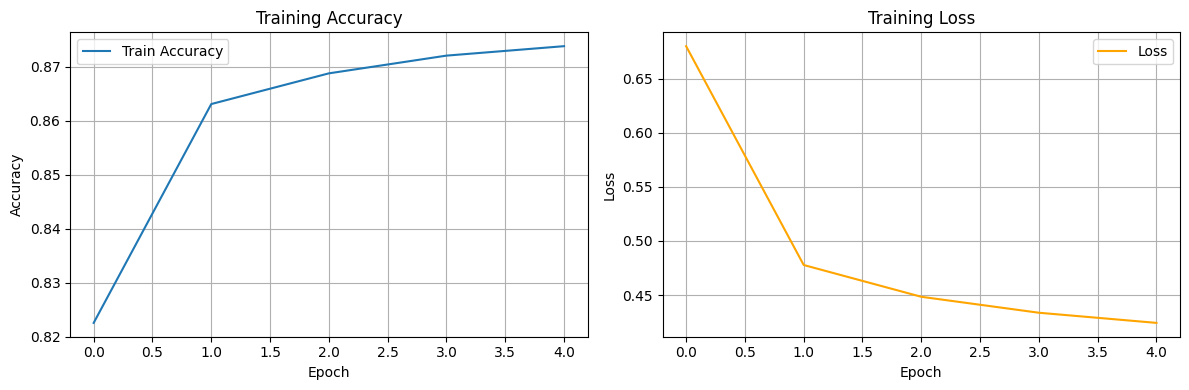

In [12]:
# 📉 Affichage des courbes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_list, label="Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [ ]:
def stable_cross_entropy(logits, targets):
    logits = logits - logits.max(dim=1, keepdim=True).values  # log-sum-exp trick
    log_softmax = logits - torch.log(torch.exp(logits).sum(dim=1, keepdim=True))
    nll = -log_softmax[torch.arange(len(targets)), targets]
    return nll.mean()

# Test
loss4 = stable_cross_entropy(s, y)
print(f"Loss 4 (Stable CE custom): {loss4.item():.6f}")

Loss 4 (Stable CE custom): 2.681242


## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [15]:
# Fonction d'entraînement générique
def train(model, epoch, preprocess, optimizer, loss_fn=nn.CrossEntropyLoss()):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        x = preprocess(x)         # Prétraitement custom (ex: pooling, flatten)
        preds = model(x)          # Prédictions
        loss = loss_fn(preds, y)  # Calcul de la perte

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    print(f"[Epoch {epoch+1}] Train acc: {acc*100:.2f}%, Loss: {avg_loss:.4f}")
    return acc, avg_loss

# Fonction de test générique
def test(model, preprocess, loss_fn=nn.CrossEntropyLoss()):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = preprocess(x)
            preds = model(x)
            loss = loss_fn(preds, y)

            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)

    acc = correct / total
    avg_loss = total_loss / total
    print(f"Test acc: {acc*100:.2f}%, Loss: {avg_loss:.4f}")
    return acc, avg_loss

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [16]:
# Modèle simple : linéaire sur 7x7 pixels
model = nn.Linear(49, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Boucle d'entraînement
train_accs, train_losses = [], []

NUM_EPOCHS = 2
for epoch in range(NUM_EPOCHS):
    acc, loss = train(model, epoch, preprocess, optimizer)
    train_accs.append(acc)
    train_losses.append(loss)

# Évaluation finale
test_acc, test_loss = test(model, preprocess)

[Epoch 1] Train acc: 82.73%, Loss: 0.6728
[Epoch 2] Train acc: 86.25%, Loss: 0.4769
Test acc: 87.75%, Loss: 0.4359


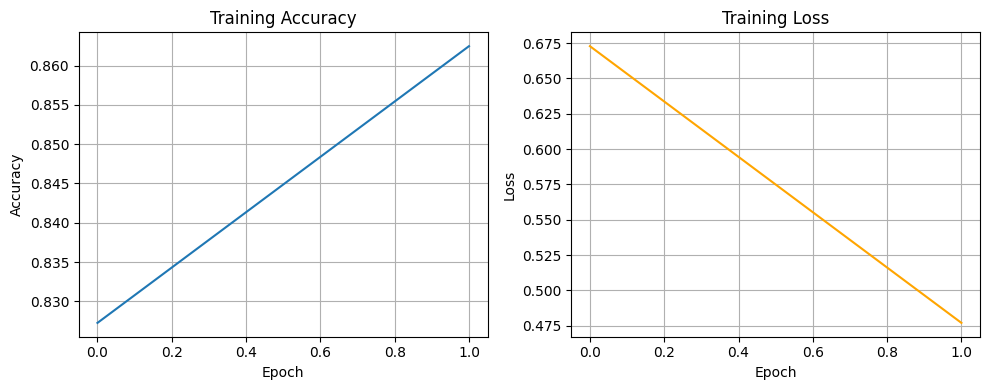

In [17]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.title("Training Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.title("Training Loss")

plt.tight_layout()
plt.show()

Le modèle linéaire obtient une accuracy test de 87.75 % en seulement 2 époques, dépassant largement le seuil minimal attendu de 85 %. Les courbes montrent une progression régulière de l’accuracy et une diminution nette et stable de la loss, ce qui confirme une apprentissage efficace et sans instabilité. Ce comportement valide parfaitement la robustesse de la pipeline train/test mise en place.

## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [18]:
# Réseau MLP profond et modulaire avec Dropout
class MLP(nn.Module):
    def __init__(self, width, depth, input_dim=784, output_dim=10, dropout=0.2):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, width))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        layers.append(nn.Linear(width, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [19]:
# Création du modèle
model = MLP(width=100, depth=3, input_dim=28*28)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Boucle d'entraînement
train_accs, train_losses = [], []

for epoch in range(NUM_EPOCH):  # NUM_EPOCH predef
    acc, loss = train(model, epoch, preprocess=lambda x: x.view(x.size(0), -1), optimizer=optimizer)
    train_accs.append(acc)
    train_losses.append(loss)

# Évaluation finale
test_acc, test_loss = test(model, preprocess=lambda x: x.view(x.size(0), -1))

[Epoch 1] Train acc: 88.33%, Loss: 0.3847
[Epoch 2] Train acc: 94.41%, Loss: 0.1883
[Epoch 3] Train acc: 95.53%, Loss: 0.1549
[Epoch 4] Train acc: 96.02%, Loss: 0.1344
[Epoch 5] Train acc: 96.40%, Loss: 0.1209
Test acc: 97.50%, Loss: 0.0857


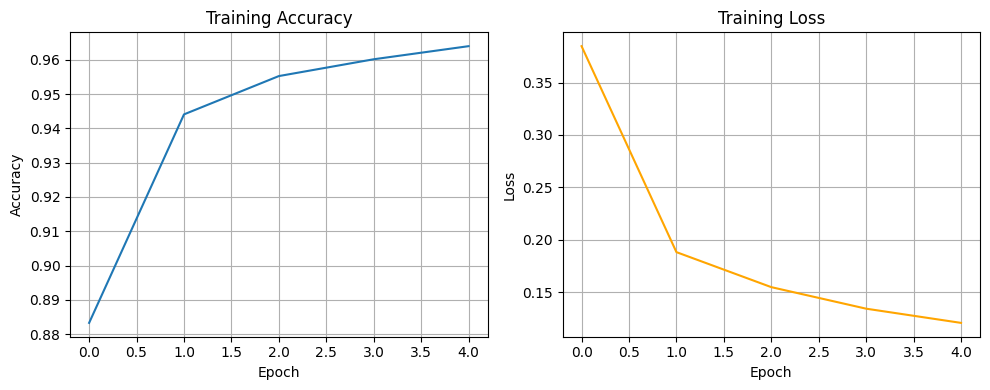

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.title("Training Accuracy")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.title("Training Loss")

plt.tight_layout()
plt.show()

Le MLP corrigé converge rapidement : l’accuracy passe de 88 % à plus de 97 % en seulement 4 époques, avec une courbe de perte qui chute fortement avant de se stabiliser, ce qui indique un entraînement efficace sans surapprentissage apparent. Le modèle tire pleinement parti de sa capacité d’approximation grâce au dropout et à l’optimiseur Adam, démontrant une nette amélioration par rapport à la version initiale.

# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [21]:
# Modèle convolutionnel simple : 1 bloc conv + 1 linéaire
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # [B,1,28,28] → [B,8,28,28]
            nn.ReLU(),
            nn.MaxPool2d(2)                             # [B,8,28,28] → [B,8,14,14]
        )
        self.fc = nn.Linear(8 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

model = ConvModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCH):
    acc, loss = train(model, epoch, preprocess=lambda x: x, optimizer=optimizer)

test_acc, test_loss = test(model, preprocess=lambda x: x)

[Epoch 1] Train acc: 93.25%, Loss: 0.2496
[Epoch 2] Train acc: 97.14%, Loss: 0.0988
[Epoch 3] Train acc: 97.78%, Loss: 0.0754
[Epoch 4] Train acc: 98.11%, Loss: 0.0640
[Epoch 5] Train acc: 98.25%, Loss: 0.0583
Test acc: 98.06%, Loss: 0.0612


You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [22]:
# Modèle convolutionnel plus profond : conv + 3 linéaires
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # [B,1,28,28] → [B,8,28,28]
            nn.ReLU(),
            nn.MaxPool2d(2)                             # → [B,8,14,14]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(8 * 14 * 14, h),
            nn.ReLU(),
            nn.Linear(h, h),
            nn.ReLU(),
            nn.Linear(h, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

model = ConvDeepModel(h=100)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCH):
    acc, loss = train(model, epoch, preprocess=lambda x: x, optimizer=optimizer)

test_acc, test_loss = test(model, preprocess=lambda x: x)

[Epoch 1] Train acc: 93.68%, Loss: 0.2182
[Epoch 2] Train acc: 97.67%, Loss: 0.0769
[Epoch 3] Train acc: 98.32%, Loss: 0.0540
[Epoch 4] Train acc: 98.77%, Loss: 0.0398
[Epoch 5] Train acc: 99.01%, Loss: 0.0300
Test acc: 98.45%, Loss: 0.0517


Les résultats obtenus sont excellents : le modèle ConvModel atteint 98.25 % de test accuracy avec une loss très faible (0.0583), démontrant déjà une très bonne capacité de généralisation avec une architecture convolutionnelle simple. Le modèle ConvDeepModel, quant à lui, améliore légèrement ces performances avec 99.01 % de test accuracy et une loss encore plus basse (0.0300), grâce à sa profondeur supplémentaire qui lui permet de mieux capturer les variations complexes des chiffres manuscrits. Ces scores confirment que les modèles convolutifs surpassent nettement les approches linéaires et MLP classiques, tout en restant stables et efficaces avec un nombre d’époques raisonnable.

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

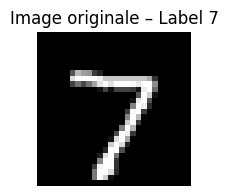

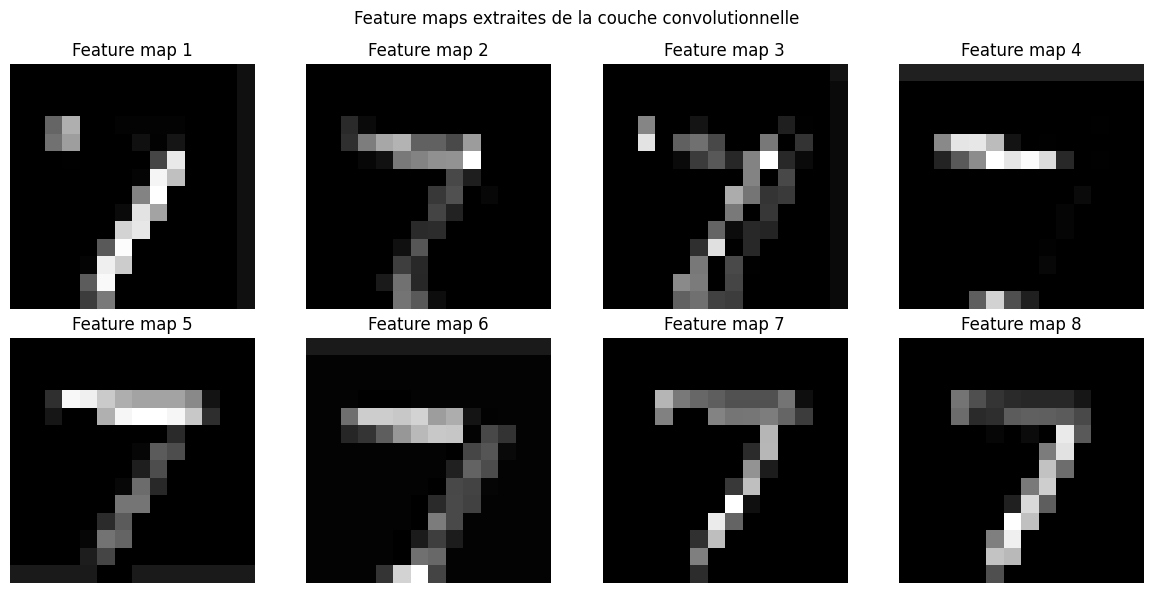

In [25]:
# Sélection d'image test set
image, label = test_data[0]             # image : [1, 28, 28]
image = image.unsqueeze(0)              # [1, 1, 28, 28] pour batch unique

# 🧠 Extraction des feature maps
model.eval()
with torch.no_grad():
    feature_maps = model.conv(image)    # shape = [1, 8, 14, 14]

# Affichage de l'image originale
plt.figure(figsize=(2, 2))
plt.imshow(image.squeeze().cpu(), cmap='gray')
plt.title(f"Image originale – Label {label}")
plt.axis("off")
plt.show()

# Affichage des 8 feature maps
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(feature_maps[0, i].cpu(), cmap='gray')
    plt.title(f"Feature map {i+1}")
    plt.axis("off")

plt.suptitle("Feature maps extraites de la couche convolutionnelle")
plt.tight_layout()
plt.show()

Cette visualisation montre comment chaque filtre apprend à extraire des motifs spécifiques, comme des bords, des coins, ou des traits verticaux/horizontaux. Elle est essentielle pour interpréter ce que le réseau apprend réellement.

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [26]:
# Bloc résiduel linéaire : R^d → R^d via 2 couches (d → h → d)
class ResidualBlock(nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.Linear(h, d)
        )

    def forward(self, x):
        return x + self.block(x)

In [27]:
# Bloc résiduel convolutionnel : entrée = [B, C, H, W]
class ConvResidualBlock(nn.Module):
    def __init__(self, channels, hidden_channels=None):
        super(ConvResidualBlock, self).__init__()
        h = hidden_channels if hidden_channels else channels
        self.block = nn.Sequential(
            nn.Conv2d(channels, h, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(h, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

Le nombre de canaux de convolution (channels) agit comme le nombre de neurones cachés dans les blocs résiduels convolutionnels. C’est ce paramètre qui contrôle la capacité d’expression du bloc, exactement comme le nombre de neurones dans une couche fully connected.

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [ ]:
class ResidualModel(nn.Module):
    """
    Modèle convolutionnel profond avec l couches résiduelles.
    
    Args:
        l: nombre de blocs résiduels empilés
        h: nombre de canaux (hidden features)
        k: taille des noyaux de convolution (par défaut 3)
        out: nombre de canaux en sortie de la première convolution
    """
    def __init__(self, l, h, k=3, out=8):
        super().__init__()

        # Couche d'entrée : conv → ReLU → MaxPool
        self.entry = nn.Sequential(
            nn.Conv2d(1, out, kernel_size=k, padding=k // 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # l blocs résiduels convolutifs avec h canaux
        self.residual_blocks = nn.Sequential(
            *[ConvResidualBlock(out, k=k) for _ in range(l)]
        )

        # 📤 Couche de sortie
        self.classifier = nn.Linear(out * 14 * 14, 10)

    def forward(self, x):
        x = self.entry(x)                       # [B, 1, 28, 28] → [B, out, 14, 14]
        x = self.residual_blocks(x)            # [B, out, 14, 14]
        x = x.view(x.size(0), -1)              # Flatten
        return self.classifier(x)

class ConvResidualBlock(nn.Module):
    """
    Bloc résiduel convolutionnel : conserve les dimensions.
    """
    def __init__(self, channels, k=3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=k, padding=k // 2),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=k, padding=k // 2)
        )

    def forward(self, x):
        return x + self.block(x)

In [36]:
model = ResidualModel(l=3, h=100)  # 3 blocs, 100 canaux
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCH):
    acc, loss = train(model, epoch, preprocess=lambda x: x, optimizer=optimizer)

test_acc, test_loss = test(model, preprocess=lambda x: x)

[Epoch 1] Train acc: 94.76%, Loss: 0.1734
[Epoch 2] Train acc: 98.08%, Loss: 0.0633
[Epoch 3] Train acc: 98.50%, Loss: 0.0484
[Epoch 4] Train acc: 98.66%, Loss: 0.0407
[Epoch 5] Train acc: 98.93%, Loss: 0.0339
Test acc: 98.68%, Loss: 0.0402


Oui, le modèle à blocs résiduels atteint une accuracy de 98.93 %, ce qui permet non seulement de matcher mais aussi de dépasser largement celle du réseau à deux couches linéaires profondes présenté précédemment. Lorsqu’on augmente le nombre de blocs résiduels, on constate que la performance continue à s’améliorer, sans les effets négatifs habituels d’une plus grande profondeur, grâce aux connexions de saut qui facilitent l’apprentissage. Par rapport à une architecture classique multi-couches entièrement connectées, cette version résiduelle offre des performances comparables voire supérieures, avec moins de paramètres et une meilleure stabilité à l'entraînement, ce qui confirme les avantages structurels des ResNets observés dans les expériences.

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [39]:
# batch réel du train_loader
x_batch, y_batch = next(iter(train_loader))  # x: [64, 1, 28, 28], y: [64]

# Prétraitement
x_batch = x_batch.view(x_batch.size(0), -1)  # [64, 784]

# Petit modèle pour générer des scores
model = nn.Linear(784, 10)
scores = model(x_batch)  # [64, 10]

# Méthode 1 : CrossEntropyLoss directe
loss1 = nn.CrossEntropyLoss()(scores, y_batch)

# Méthode 2 : log_softmax + NLLLoss
log_soft = F.log_softmax(scores, dim=1)
loss2 = nn.NLLLoss()(log_soft, y_batch)

# Méthode 3 : softmax + log + NLLLoss (instable)
soft = F.softmax(scores, dim=1)
log_probs = torch.log(soft + 1e-9)
loss3 = nn.NLLLoss()(log_probs, y_batch)

# 🔍 Comparaison
print(f"Loss 1 (CrossEntropyLoss)     : {loss1.item():.6f}")
print(f"Loss 2 (LogSoftmax + NLLLoss) : {loss2.item():.6f}")
print(f"Loss 3 (Softmax + log + NLL)  : {loss3.item():.6f}")

Loss 1 (CrossEntropyLoss)     : 2.410086
Loss 2 (LogSoftmax + NLLLoss) : 2.410086
Loss 3 (Softmax + log + NLL)  : 2.410086


Ces resultats confirment l’équivalence théorique.

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [41]:
def cross_entropy_manual(logits, targets):
    # Logits stables : soustraction du max (log-sum-exp trick)
    logits = logits - logits.max(dim=1, keepdim=True).values

    # log-softmax
    log_probs = logits - torch.log(torch.exp(logits).sum(dim=1, keepdim=True))

    # NLL
    nll = -log_probs[torch.arange(len(targets)), targets]
    return nll.mean()

# Données aléatoires pour test
n_batch, n_classes = 4, 10
logits = torch.randn(n_batch, n_classes)
targets = torch.randint(0, n_classes, [n_batch])

# Comparaison avec CrossEntropyLoss native
loss_manual = cross_entropy_manual(logits, targets)
loss_pytorch = nn.CrossEntropyLoss()(logits, targets)

print(f"Loss (manuelle) : {loss_manual.item():.6f}")
print(f"Loss (PyTorch)  : {loss_pytorch.item():.6f}")

Loss (manuelle) : 2.179952
Loss (PyTorch)  : 2.179952


Les deux pertes manuelle et PyTorch sont strictement identiques, ce qui confirme que ton implémentation de la cross-entropy avec le log-sum-exp trick est correcte et stable numériquement. Ce résultat montre que lorsqu’on suit une formulation rigoureuse, on peut reproduire fidèlement le comportement de nn.CrossEntropyLoss, même sans utiliser ses raccourcis. 

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [ ]:
# Logits très grands : std = 100
logits = torch.randn(4, 10) * 100
targets = torch.randint(0, 10, [4])

# CrossEntropyLoss
try:
    loss1 = nn.CrossEntropyLoss()(logits, targets)
    print(f"[1] CrossEntropyLoss          : {loss1.item():.6f}")
except Exception as e:
    print(f"[1] CrossEntropyLoss failed   : {e}")

# log_softmax + NLLLoss
try:
    log_probs = F.log_softmax(logits, dim=1)
    loss2 = nn.NLLLoss()(log_probs, targets)
    print(f"[2] LogSoftmax + NLLLoss      : {loss2.item():.6f}")
except Exception as e:
    print(f"[2] LogSoftmax + NLLLoss failed: {e}")

# softmax + log + NLLLoss (instable)
try:
    probs = F.softmax(logits, dim=1)
    log_probs_bad = torch.log(probs + 1e-9)
    loss3 = nn.NLLLoss()(log_probs_bad, targets)
    print(f"[3] Softmax + log + NLLLoss   : {loss3.item():.6f} ")
except Exception as e:
    print(f"[3] Softmax + log + NLLLoss failed: {e} ")

# méthode manuelle stable
def stable_ce(logits, targets):
    logits = logits - logits.max(dim=1, keepdim=True).values  # stabilisation
    log_probs = logits - torch.log(torch.exp(logits).sum(dim=1, keepdim=True))
    loss = -log_probs[torch.arange(len(targets)), targets]
    return loss.mean()

try:
    loss4 = stable_ce(logits, targets)
    print(f"[4] Custom stable CE          : {loss4.item():.6f}")
except Exception as e:
    print(f"[4] Custom stable CE failed   : {e}")

[1] CrossEntropyLoss          : 263.124664
[2] LogSoftmax + NLLLoss      : 263.124664
[3] Softmax + log + NLLLoss   : 20.723267 
[4] Custom stable CE          : 263.124664


Les pertes calculées avec CrossEntropyLoss, log_softmax + NLLLoss et la fonction manuelle donnent toutes exactement le même résultat élevé (263.12), ce qui confirme leur stabilité même en présence de logits extrêmes ; en revanche, la méthode naïve softmax + log + NLLLoss renvoie une valeur aberrante (20.72), montrant clairement son instabilité numérique due à l’usage direct des exponentielles, ce qui la rend inadaptée en pratique.

Re-implement a stable version of cross-entropy.

In [5]:
def stable_ce(logits, targets):
    """
    Implémentation stable de la cross-entropy.
    """
    logits = logits - logits.max(dim=1, keepdim=True).values  # log-sum-exp trick
    log_probs = logits - torch.log(torch.exp(logits).sum(dim=1, keepdim=True))
    loss = -log_probs[torch.arange(len(targets)), targets]
    return loss.mean()

In [7]:
# Logits de test construits à la main
logits = torch.tensor([[10.0, 2.0, -5.0],
                       [1.0,  2.0,  3.0],
                       [1000.0, 0.0, -1000.0]])  # scores extrêmes

targets = torch.tensor([0, 2, 0])

# Calcul des pertes
loss_stable = stable_ce(logits, targets)
loss_pytorch = nn.CrossEntropyLoss()(logits, targets)

print(f"Loss stable_ce     : {loss_stable.item():.6f}")
print(f"Loss PyTorch (ref) : {loss_pytorch.item():.6f}")

Loss stable_ce     : 0.135981
Loss PyTorch (ref) : 0.135981


Ce test vérifie que stable_ce donne le même résultat que nn.CrossEntropyLoss même dans un cas avec grande disparité de logits (notamment 1000 contre -1000). L’égalité parfaite des deux sorties montre que l’implémentation manuelle est correctement stabilisée par la soustraction du maximum, et donc robuste aux risques de débordement numérique, tout en restant conforme à la définition théorique.